In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# !pip install tensorflow-gpu==2.0.0-rc1
# !pip install 'h5py==2.10.0' --force-reinstall

In [2]:
import numpy as np

rows = np.loadtxt("./lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

983


In [3]:
import numpy as np

# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):

    ohbin = np.zeros(45) #45개의 빈 칸을 만듬

    for i in range(6): #여섯개의 당첨번호에 대해서 반복함
        ohbin[int(numbers[i])-1] = 1 #로또번호가 1부터 시작하지만 벡터의 인덱스 시작은 0부터 시작하므로 1을 뺌
    
    return ohbin

# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [4]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))  # map이 무엇인가?

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

#원핫인코딩으로 표시
print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


In [5]:
train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 900), test: (901, 982)


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델을 정의합니다.
model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])

# 모델을 컴파일합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'
          .format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), 
          np.mean(batch_val_acc), np.mean(batch_val_loss)))

epoch    0 train acc 0.013 loss 0.409 val acc 0.051 loss 0.399
epoch    1 train acc 0.018 loss 0.396 val acc 0.051 loss 0.398
epoch    2 train acc 0.021 loss 0.394 val acc 0.061 loss 0.398
epoch    3 train acc 0.019 loss 0.392 val acc 0.040 loss 0.399
epoch    4 train acc 0.028 loss 0.389 val acc 0.040 loss 0.401
epoch    5 train acc 0.033 loss 0.384 val acc 0.020 loss 0.405
epoch    6 train acc 0.029 loss 0.378 val acc 0.040 loss 0.408
epoch    7 train acc 0.031 loss 0.372 val acc 0.051 loss 0.411
epoch    8 train acc 0.040 loss 0.365 val acc 0.040 loss 0.415
epoch    9 train acc 0.044 loss 0.358 val acc 0.030 loss 0.419
epoch   10 train acc 0.051 loss 0.351 val acc 0.030 loss 0.424
epoch   11 train acc 0.055 loss 0.343 val acc 0.040 loss 0.429
epoch   12 train acc 0.064 loss 0.335 val acc 0.040 loss 0.434
epoch   13 train acc 0.075 loss 0.326 val acc 0.020 loss 0.440
epoch   14 train acc 0.075 loss 0.316 val acc 0.020 loss 0.446
epoch   15 train acc 0.090 loss 0.306 val acc 0.020 los

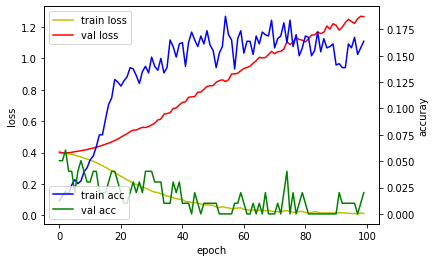

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [10]:
# 88회부터 지금까지 1등부터 5등까지 상금의 평균낸다.
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)   

[2432458340.3627234, 57187544.32589286, 1450798.6908482143, 52757.78794642857, 5000.0]


In [11]:
# 등수와 상금을 반환함
# 순위에 오르지 못한 경우에는 등수가 0으로 반환함
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [12]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [13]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) # 모델의 출력값을 얻음
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int) # 6등까지 변수

    for n in range(10): # 10판 수행
        numbers = gen_numbers_from_probability(ys_pred[0])
        
        #i회차 입력 후 나온 출력을 i+1회차와 비교함
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')    

[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   6   0   3   1   0   0  14,599,155,196
[   2]   6   0   4   0   0   0  14,600,553,236
[   3]   2   0   4   4   0   0   4,870,930,906
[   4]   2   0   6   2   0   0   4,873,726,988
[   5]   2   0   7   1   0   0   4,875,125,029
[   6]   5   0   3   2   0   0  12,166,749,613
[   7]   4   0   6   0   0   0   9,738,538,153
[   8]   5   0   4   1   0   0  12,168,147,654
[   9]   3   0   6   1   0   0   7,306,132,571
[  10]   4   1   3   1   1   0   9,791,431,059
[  11]   0   0   2   8   0   0       3,323,659
[  12]   4   0   2   3   1   0   9,732,898,232
[  13]   6   0   2   2   0   0  14,597,757,155
[  14]   2   0   3   3   2   0   4,869,437,350
[  15]   1   0   8   1   0   0   2,444,117,487
[  16]   4   0   4   2   0   0   9,735,742,071
[  17]   2   0   5   3   0   0   4,872,328,947
[  18]   4   0   5   1   0   0   9,737,140,112
[  19]   4   1   3   2   0   0   9,791,478,817
[  20]   4   0   6   0   0   0   9,738,538,153
[  21]   1   0   7   

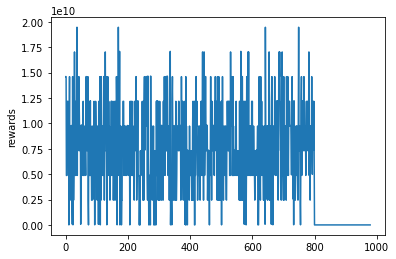

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

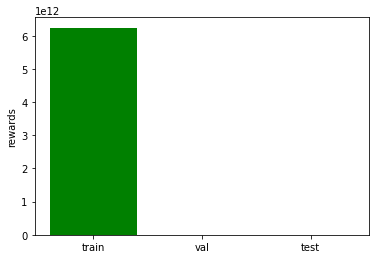

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [16]:
# 최대 100번 에포크까지 수행
for epoch in range(100):

    model.reset_states() # 중요! 매 에포크마다 1회부터 다시 훈련하므로 상태 초기화 필요

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) #배치만큼 모델에 학습시킴

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'
          .format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))  

epoch    0 train acc 0.145 loss 0.123
epoch    1 train acc 0.147 loss 0.157
epoch    2 train acc 0.148 loss 0.157
epoch    3 train acc 0.150 loss 0.150
epoch    4 train acc 0.149 loss 0.143
epoch    5 train acc 0.150 loss 0.136
epoch    6 train acc 0.152 loss 0.130
epoch    7 train acc 0.154 loss 0.125
epoch    8 train acc 0.154 loss 0.120
epoch    9 train acc 0.155 loss 0.115
epoch   10 train acc 0.156 loss 0.111
epoch   11 train acc 0.157 loss 0.107
epoch   12 train acc 0.157 loss 0.103
epoch   13 train acc 0.157 loss 0.100
epoch   14 train acc 0.157 loss 0.096
epoch   15 train acc 0.158 loss 0.093
epoch   16 train acc 0.158 loss 0.091
epoch   17 train acc 0.159 loss 0.089
epoch   18 train acc 0.160 loss 0.086
epoch   19 train acc 0.161 loss 0.084
epoch   20 train acc 0.161 loss 0.081
epoch   21 train acc 0.162 loss 0.079
epoch   22 train acc 0.162 loss 0.078
epoch   23 train acc 0.162 loss 0.076
epoch   24 train acc 0.163 loss 0.075
epoch   25 train acc 0.163 loss 0.073
epoch   26 t

In [1]:
# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers


NameError: name 'x_samples' is not defined